# Style transfer using VGG16 network

* `A Neural Algorithm of Artistic Style`, [arXiv:1508.06576](https://arxiv.org/abs/1508.06576)
* Leon A. Gatys, Alexander S. Ecker, and, Matthias Bethge


* `models/research/slim/nets`을 이용하여 만듦
* `image_size=224`로 고정
* 논문과는 달리 원래 vgg모델처럼 `max_pooling`을 사용 (논문은 `average_pooling` 사용)
  * `02_style_transfer.ipynb`에서는 vgg를 직접 수정하여 사용
* loss는 논문에 나온 그대로 사용 (조금 맘에 안들지만)
* hyperparameter들은 cs20 코드를 참조함
* input_image는 우리집 고양이
* style_image는 [Starry Night](https://en.wikipedia.org/wiki/The_Starry_Night)

In [1]:
import sys
sys.path.insert(0, 'D:/PythonLab/CS20/models-master/research/slim/')
# sys.path.append('D:/PythonLab/CS20/models-master/research/slim/') 

In [2]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import tensorflow as tf

slim = tf.contrib.slim

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Instructions for updating:
Use the retry module or similar alternatives.


### Hyperparameters setting

In [3]:
content_image_name = 'my_cat1.jpg'
style_image_name = 'Gogh_The_Starry_Night.jpg'
image_size = L = 224
noise_ratio = 0.4
style_loss_weight = np.array([0.5, 1.0, 1.5, 3.0, 4.0])
content_weight = 0.00001 #0.0008 #0.001 #0.00001
style_weight = 1.0
learning_rate = 0.01
max_steps = 1000
print_steps = 100

### Load a VGG16 graph

In [4]:
from nets import vgg

In [5]:
# 여기를 직접 채워 넣으시면 됩니다.
content_image_p = tf.placeholder(dtype=tf.float32, shape=[1,L,L,3], name='content_img_p')
style_image_p = tf.placeholder(dtype=tf.float32, shape=[1,L,L,3], name='style_img_p')
content_image = tf.get_variable(name='content_img', shape=[1,L,L,3] ,trainable=False)
style_image = tf.get_variable(name='style_img', shape=[1,L,L,3],trainable=False)
generated_image = tf.get_variable(name='generated_image',
                                  shape=[1, L, L, 3],
                                  initializer=tf.random_uniform_initializer(minval=-0.2, maxval=0.2))

In [6]:
# tf.placeholder를 tf.Variable로 바꿈
content_image_op = content_image.assign(content_image_p)
style_image_op = style_image.assign(style_image_p)

In [7]:
# 초기 이미지는 content_image에 random noise를 섞음
generated_image_op = generated_image.assign(generated_image * noise_ratio + \
                                            content_image_p * (1.0 - noise_ratio))
# 여기를 직접 채워 넣으시면 됩니다.
# generated_image는 매 update 후에 [-1, 1] 사이로 clipping
generated_image_clipping = generated_image.assign(tf.clip_by_value(generated_image, -1.0, 1.0))

In [8]:
# 여기를 직접 채워 넣으시면 됩니다.
with tf.variable_scope(name_or_scope='vgg16', reuse=tf.AUTO_REUSE) as scope: #reuse=tf.AUTO_REUSE
    # net(output of logit layer), end_points(OrderdDict of intermediate activation)
    _, feature_maps_c = vgg.vgg_16(content_image, num_classes=None, is_training=False)
    # 그냥 돌리면 두번째 vgg를 호출할 때 에러가 난다.
    # scope.reuse_variables()
    _, feature_maps_s = vgg.vgg_16(style_image, num_classes=None, is_training=False)
    # scope.reuse_variables()
    _, feature_maps_g = vgg.vgg_16(generated_image, num_classes=None, is_training=False)

```python
scope='vgg16'

_, feature_maps_c = vgg.vgg_16(content_image, num_classes=None, is_training=False, scope=scope)

scope=tf.VariableScope(reuse=True, name='vgg16')
_, feature_maps_s = vgg.vgg_16(style_image, num_classes=None, is_training=False,scope=scope)
_, feature_maps_g = vgg.vgg_16(generated_image, num_classes=None, is_training=False,scope=scope)
```

In [9]:
# with tf.Session() as sess:
#     writer = tf.summary.FileWriter("./graphs/01_style_transfer", sess.graph)
#     writer.close()

In [10]:
for key, value in feature_maps_c.items():
    print(key)

vgg16/vgg_16/conv1/conv1_1
vgg16/vgg_16/conv1/conv1_2
vgg16/vgg_16/pool1
vgg16/vgg_16/conv2/conv2_1
vgg16/vgg_16/conv2/conv2_2
vgg16/vgg_16/pool2
vgg16/vgg_16/conv3/conv3_1
vgg16/vgg_16/conv3/conv3_2
vgg16/vgg_16/conv3/conv3_3
vgg16/vgg_16/pool3
vgg16/vgg_16/conv4/conv4_1
vgg16/vgg_16/conv4/conv4_2
vgg16/vgg_16/conv4/conv4_3
vgg16/vgg_16/pool4
vgg16/vgg_16/conv5/conv5_1
vgg16/vgg_16/conv5/conv5_2
vgg16/vgg_16/conv5/conv5_3
vgg16/vgg_16/pool5
vgg16/vgg_16/fc6
vgg16/vgg_16/fc7


## Build a model

### collecte feature maps

* content layers
  * `conv4_2`: key name -> 'vgg16/vgg_16/conv4/conv4_2'
* style layers
  * `conv1_1`: key name -> 'vgg16/vgg_16/conv1/conv1_1'
  * `conv2_1`: key name -> 'vgg16/vgg_16/conv2/conv2_1'
  * `conv3_1`: key name -> 'vgg16/vgg_16/conv3/conv3_1'
  * `conv4_1`: key name -> 'vgg16/vgg_16/conv4/conv4_1'
  * `conv5_1`: key name -> 'vgg16/vgg_16/conv5/conv5_1'

In [11]:
content_layers = feature_maps_c['vgg16/vgg_16/conv4/conv4_2']
style_layers = [feature_maps_s['vgg16/vgg_16/conv1/conv1_1'],
                feature_maps_s['vgg16/vgg_16/conv2/conv2_1'],
                feature_maps_s['vgg16/vgg_16/conv3/conv3_1'],
                feature_maps_s['vgg16/vgg_16/conv4/conv4_1'],
                feature_maps_s['vgg16/vgg_16/conv5/conv5_1']]
generated_layers = [feature_maps_g['vgg16/vgg_16/conv4/conv4_2'],
                    feature_maps_g['vgg16/vgg_16/conv1/conv1_1'],
                    feature_maps_g['vgg16/vgg_16/conv2/conv2_1'],
                    feature_maps_g['vgg16/vgg_16/conv3/conv3_1'],
                    feature_maps_g['vgg16/vgg_16/conv4/conv4_1'],
                    feature_maps_g['vgg16/vgg_16/conv5/conv5_1']]

In [12]:
print(content_layers.shape)

(1, 28, 28, 512)


In [13]:
for layer in style_layers:
    print(layer.shape)

(1, 224, 224, 64)
(1, 112, 112, 128)
(1, 56, 56, 256)
(1, 28, 28, 512)
(1, 14, 14, 512)


In [14]:
for layer in generated_layers:
    print(layer.shape)

(1, 28, 28, 512)
(1, 224, 224, 64)
(1, 112, 112, 128)
(1, 56, 56, 256)
(1, 28, 28, 512)
(1, 14, 14, 512)


### content loss

In [15]:
def content_loss(P, F, scope):
    """Calculate the content loss function between
    the feature maps of content image and generated image.

    Args:
    P: the feature maps of the content image
    F: the feature maps of the generated image
    scope: scope

    Returns:
    loss: content loss (mean squared loss)
    """
    # 여기를 직접 채워 넣으시면 됩니다.
    with tf.name_scope(scope):
        P_shape = P.get_shape().as_list() # [1, width, height, num of feature map]
        P_vectorized = tf.reshape(P, [P_shape[-1], -1]) # num of feature map x (width x height)

        F_shape = F.get_shape().as_list()
        F_vectorized = tf.reshape(F, [F_shape[-1], -1]) # feature map x (width x height)
        
        loss = tf.reduce_sum(tf.square(F_vectorized-P_vectorized))/2.0
        # loss = tf.reduce_sum(tf.square(F-P))/2.0
    return loss

### style loss

In [16]:
def style_loss(style_layers, generated_layers, scope):
    """Calculate the style loss function between
    the gram matrix of feature maps of style image and generated image.

    Args:
    style_layers: list of the feature maps of the style image
    generated_layers: list of the feature maps of the generated image
    scope: scope

    Returns:
    loss: style loss (mean squared loss)
    """
    def _style_loss_one_layer(feature_map_s, feature_map_g):
        """Calculate the style loss for one layer.
        Args:
          feature_map_s: the feature map of the style image
            - G: the gram matrix of the feature_map_s
          feature_map_g: the feature map of the generated image
            - A: the gram matrix of the feature_map_g

        Returns:
          loss: style loss for one layer (mean squared loss)
        """
        assert feature_map_s.shape == feature_map_g.shape
        _, h, w, c = feature_map_s.get_shape().as_list()
        G = _gram_matrix(feature_map_s)
        A = _gram_matrix(feature_map_g)
        # 여기를 직접 채워 넣으시면 됩니다.
        normalization_term = ((h*w)**2) * (c**2) 
        loss = tf.reduce_sum(tf.square(G-A))/normalization_term
        return loss
  
    def _gram_matrix(feature_map):
        """Calculate the gram matrix for the feature map
        Args:
          feature_map: 4-rank Tensor [1, height, width, channels]
            - F = 2-rank Tensor [h * w, channels]

        Returns:
          gram_matrix: 2-rank Tensor [c, c] (F.transpose x F)
        """
        # 여기를 직접 채워 넣으시면 됩니다.
        F = tf.squeeze(feature_map)
        h, w, c = F.shape
        F = tf.reshape(F, [h*w, c])
        return tf.matmul(tf.transpose(F), F) # tf.tensordot(F, F, 1)
    
    
    assert len(style_layers) == len(generated_layers)
    with tf.name_scope(scope):  
        loss = 0.0
        for i in range(len(style_layers)):
            loss_one = _style_loss_one_layer(style_layers[i], generated_layers[i])
            loss += loss_one * style_loss_weight[i]

    return loss * 0.25

### Total loss

In [17]:
loss_c = content_loss(content_layers, generated_layers[0],
                      scope='content_loss')
loss_s = style_loss(style_layers, generated_layers[1:],
                    scope='style_loss')

with tf.variable_scope('total_loss'):
    total_loss = content_weight * loss_c + style_weight * loss_s

In [18]:
print(type(total_loss))

<class 'tensorflow.python.framework.ops.Tensor'>


### Define a optimizer

In [19]:
# 여기를 직접 채워 넣으시면 됩니다.
with tf.name_scope('loss'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(total_loss, var_list=generated_image)

In [20]:
graph_location  = "./graphs/01_style_transfer"
print('Saving grapg to: %s' % graph_location)
# open FileWriter
train_writer = tf.summary.FileWriter(graph_location)
# add current default graph to the writer
train_writer.add_graph(tf.get_default_graph())

Saving grapg to: ./graphs/01_style_transfer


### Restore VGG16 weights using `tf.saver.restore`

### Download the VGG16 checkpoint: 

```
$ CHECKPOINT_DIR='./checkpoints'
$ mkdir ${CHECKPOINT_DIR}
$ cd ${CHECKPOINT_DIR}
$ wget http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz
$ tar -xvf vgg_16_2016_08_28.tar.gz
$ rm vgg_16_2016_08_28.tar.gz
```

In [21]:
checkpoint_path = os.path.join('D:/PythonLab/CS20/models-master/research/slim/', 
                              'PRETRAINEDCHECKPOINTDIR/vgg_16.ckpt')

In [22]:
checkpoint_path

'D:/PythonLab/CS20/models-master/research/slim/PRETRAINEDCHECKPOINTDIR/vgg_16.ckpt'

### Read a image

In [23]:
def image_preprocessing(image):
    """image preprocessing
    transform image pixel value: int [0, 255] -> float [-1.0, 1.0]

    Args:
    image: PIL image format

    Returns:
    image: resized image with numpy array type [1, h, w, 3] which is in [-1, 1]
    """
    # resize
    image = image.resize((L, L))
    # normalize
    image = np.asarray(image) / 255.
    # now [0,1]
    
    image -= 0.5
    # now [-0.5, 0.5]
    
    image *= 2.0
    # now [-1.0, 1.0]
    
    image = np.expand_dims(image, axis=0)
    # now shape=(1, L, L, 3)
    return image 

In [24]:
image_path = os.path.join('D:/PythonLab/CS20/models-master/research/slim/', 
                              'input_data/')

In [25]:
content_image_ = Image.open(image_path + content_image_name)
style_image_ = Image.open(image_path + style_image_name)

print(content_image_.size)

content_image_ = image_preprocessing(content_image_)
style_image_ = image_preprocessing(style_image_)
print(content_image_.shape)

(1709, 1709)
(1, 224, 224, 3)


In [26]:
def print_image(image):
    """print image

    Args:
    image: 4-rank np.array [1, h, w, 3]
    """
    print_image = np.squeeze(image, axis=0)
    # now (L, L, 3)
    print_image = np.clip(print_image, -1.0, 1.0)
    # now [-1.0, 1.0]
    print_image += 1.0
    # now [0, 2.0]
    print_image /= 2.0
    # now [0, 1.0]

    plt.axis('off')
    plt.imshow(print_image)
    plt.show()

In [27]:
v = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='vgg16') #tf.trainable_variables(scope='vgg16')

In [28]:
v

[<tf.Variable 'vgg16/vgg_16/conv1/conv1_1/weights:0' shape=(3, 3, 3, 64) dtype=float32_ref>,
 <tf.Variable 'vgg16/vgg_16/conv1/conv1_1/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'vgg16/vgg_16/conv1/conv1_2/weights:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'vgg16/vgg_16/conv1/conv1_2/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'vgg16/vgg_16/conv2/conv2_1/weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'vgg16/vgg_16/conv2/conv2_1/biases:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'vgg16/vgg_16/conv2/conv2_2/weights:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 <tf.Variable 'vgg16/vgg_16/conv2/conv2_2/biases:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'vgg16/vgg_16/conv3/conv3_1/weights:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'vgg16/vgg_16/conv3/conv3_1/biases:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'vgg16/vgg_16/conv3/conv3_2/weights:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Va

In [29]:
var = {}
for t_var in v:
    key = t_var.op.name.replace('vgg16/', '')
    var.update({key: t_var})

In [30]:
var

{'vgg_16/conv1/conv1_1/biases': <tf.Variable 'vgg16/vgg_16/conv1/conv1_1/biases:0' shape=(64,) dtype=float32_ref>,
 'vgg_16/conv1/conv1_1/weights': <tf.Variable 'vgg16/vgg_16/conv1/conv1_1/weights:0' shape=(3, 3, 3, 64) dtype=float32_ref>,
 'vgg_16/conv1/conv1_2/biases': <tf.Variable 'vgg16/vgg_16/conv1/conv1_2/biases:0' shape=(64,) dtype=float32_ref>,
 'vgg_16/conv1/conv1_2/weights': <tf.Variable 'vgg16/vgg_16/conv1/conv1_2/weights:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 'vgg_16/conv2/conv2_1/biases': <tf.Variable 'vgg16/vgg_16/conv2/conv2_1/biases:0' shape=(128,) dtype=float32_ref>,
 'vgg_16/conv2/conv2_1/weights': <tf.Variable 'vgg16/vgg_16/conv2/conv2_1/weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 'vgg_16/conv2/conv2_2/biases': <tf.Variable 'vgg16/vgg_16/conv2/conv2_2/biases:0' shape=(128,) dtype=float32_ref>,
 'vgg_16/conv2/conv2_2/weights': <tf.Variable 'vgg16/vgg_16/conv2/conv2_2/weights:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 'vgg_16/conv3/conv3_1/biases': 

In [31]:
saver = tf.train.Saver(var_list=var)

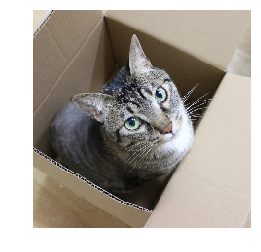

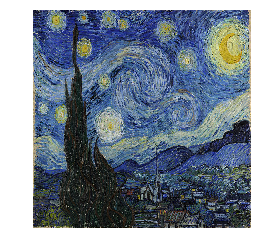

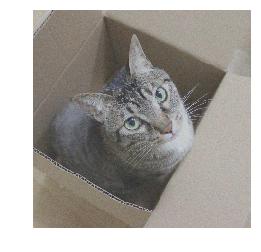

INFO:tensorflow:Restoring parameters from D:/PythonLab/CS20/models-master/research/slim/PRETRAINEDCHECKPOINTDIR/vgg_16.ckpt
step: 0  loss: 828.667236328125  duration: 2.0813889503479004 loss_c: 484774.0 loss_s: 823.8195190429688


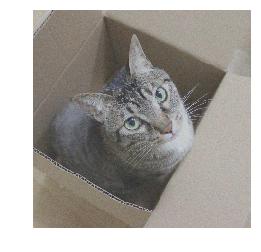

step: 100  loss: 42.913352966308594  duration: 3.276240348815918 loss_c: 2462930.0 loss_s: 18.284053802490234


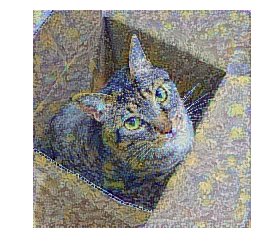

step: 200  loss: 34.926483154296875  duration: 3.2667741775512695 loss_c: 2273321.5 loss_s: 12.193267822265625


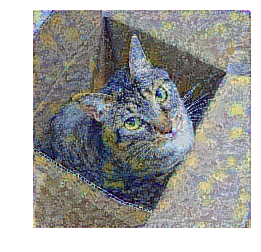

step: 300  loss: 31.848621368408203  duration: 3.26637864112854 loss_c: 2184691.5 loss_s: 10.001707077026367


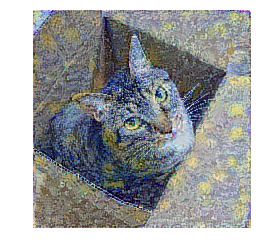

step: 400  loss: 30.131013870239258  duration: 3.2702250480651855 loss_c: 2125900.5 loss_s: 8.87200927734375


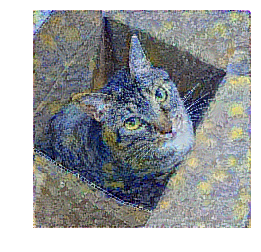

step: 500  loss: 29.0041561126709  duration: 3.27539324760437 loss_c: 2083222.75 loss_s: 8.171928405761719


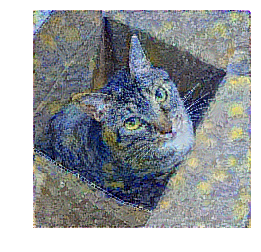

step: 600  loss: 28.203933715820312  duration: 3.2810254096984863 loss_c: 2051508.0 loss_s: 7.6888532638549805


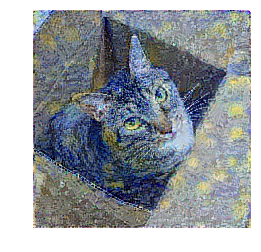

step: 700  loss: 27.599002838134766  duration: 3.299100160598755 loss_c: 2027481.5 loss_s: 7.324188709259033


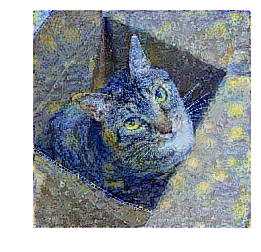

step: 800  loss: 27.122875213623047  duration: 3.361368417739868 loss_c: 2006915.0 loss_s: 7.0537261962890625


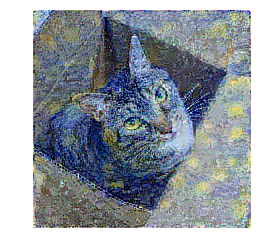

step: 900  loss: 26.736492156982422  duration: 3.284641981124878 loss_c: 1990179.25 loss_s: 6.834700584411621


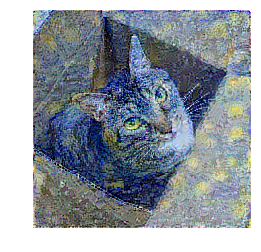

step: 1000  loss: 26.41897201538086  duration: 3.277434825897217 loss_c: 1975325.5 loss_s: 6.665719032287598


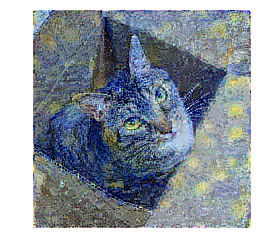

training done!


In [32]:
with tf.Session(config=sess_config) as sess:
    sess.run(tf.global_variables_initializer())
    sess.run([content_image_op, style_image_op, generated_image_op],
           feed_dict={content_image_p: content_image_,
                      style_image_p: style_image_})

    _, generated_image_ = sess.run([generated_image_clipping, generated_image])
    print_image(content_image_)
    print_image(style_image_)
    print_image(generated_image_) # initial_image = content_image + small noise

    # use saver object to load variables from the saved model
    saver.restore(sess, checkpoint_path)
  
    start_time = time.time()
    for step in range(max_steps+1):
        _, loss_, _, generated_image_,loss_c_, loss_s_ = \
        sess.run([train_op, total_loss, generated_image_clipping, generated_image,loss_c, loss_s])
        if step % print_steps == 0:
            duration = time.time() - start_time
            start_time = time.time()
            print("step: {}  loss: {}  duration: {} loss_c: {} loss_s: {}".format(step, loss_, duration, loss_c_, loss_s_))
            print_image(generated_image_)
    print('training done!')

In [33]:
def save_image(image, filename):
    """print image

    Args:
    image: 4-rank np.array [1, h, w, 3]
    filename: name of saved image
    """
    save_image = np.squeeze(image, axis=0)
    save_image = np.clip(save_image, -1.0, 1.0)
    save_image += 1.0
    save_image /= 2.0

    save_image = Image.fromarray(np.uint8(save_image*255))
    save_image.save(filename)

In [34]:
save_image(generated_image_, content_image_name)